<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Выводы</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

# Проект для «Викишоп»

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Обучите модель классифицировать комментарии на позитивные и негативные. В вашем распоряжении набор данных с разметкой о токсичности правок.

Постройте модель со значением метрики качества *F1* не меньше 0.75. 

**Инструкция по выполнению проекта**

1. Загрузите и подготовьте данные.
2. Обучите разные модели. 
3. Сделайте выводы.

Для выполнения проекта применять *BERT* необязательно, но вы можете попробовать.

**Описание данных**

Данные находятся в файле `toxic_comments.csv`. Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

## Подготовка

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import re
import spacy

In [2]:

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier


from sklearn.model_selection import GridSearchCV
from nltk.corpus import stopwords as nltk_stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import f1_score
from sklearn.ensemble import GradientBoostingClassifier

In [3]:
df = pd.read_csv('/datasets/toxic_comments.csv')

In [4]:
df

,Unnamed: 0,text,toxic
0,0,Explanation\nWhy the edits made under my usern...,0
1,1,D'aww! He matches this background colour I'm s...,0
2,2,"Hey man, I'm really not trying to edit war. It...",0
3,3,"""\nMore\nI can't make any real suggestions on ...",0
4,4,"You, sir, are my hero. Any chance you remember...",0
...,...,...,...
159287,159446,""":::::And for the second time of asking, when ...",0
159288,159447,You should be ashamed of yourself \n\nThat is ...,0
159289,159448,"Spitzer \n\nUmm, theres no actual article for ...",0
159290,159449,And it looks like it was actually you who put ...,0


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159292 entries, 0 to 159291
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Unnamed: 0  159292 non-null  int64 
 1   text        159292 non-null  object
 2   toxic       159292 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 3.6+ MB


In [6]:
df.isna().sum() # Посмотрим пропуски.

Unnamed: 0    0
text          0
toxic         0
dtype: int64

In [7]:
print(df.duplicated().sum()) # Проверим есть ли явные дублекаты

0


0    143106
1     16186
Name: toxic, dtype: int64


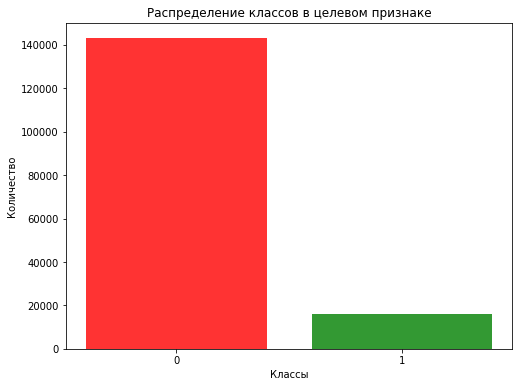

In [8]:
# загрузим данные и выведем количество объектов каждого класса

count_classes = df['toxic'].value_counts()
print(count_classes)

# создаем график
plt.figure(figsize=(8, 6))
plt.bar(count_classes.index, count_classes.values, alpha=0.8, color=['red', 'green'])
plt.xticks([0, 1], ['0', '1'])
plt.ylabel('Количество')
plt.xlabel('Классы')
plt.title('Распределение классов в целевом признаке')
plt.show()

Набоюдается распределения смещения классов (значит линейную регресию использовать небудем).

Очистим тексты от символов и приведем все в нижнему регистру:

In [9]:
def clean_data(row):
    row = re.sub(r"(?:\n|\r)", " ", row)
    row = re.sub(r"[^a-zA-Z ]+", "", row).strip()
    row = row.lower()
    return row

df['text'] = df['text'].apply(clean_data)
df.head()

,Unnamed: 0,text,toxic
0,0,explanation why the edits made under my userna...,0
1,1,daww he matches this background colour im seem...,0
2,2,hey man im really not trying to edit war its j...,0
3,3,more i cant make any real suggestions on impro...,0
4,4,you sir are my hero any chance you remember wh...,0


Разделим датасет.

In [10]:
# df_train_valid, df_test = train_test_split(df, test_size = 0.1, random_state = 12345)
# df_train, df_valid = train_test_split(df_train_valid, shuffle=False, test_size=0.25, random_state = 12345)
# print(df_train.shape, df_valid.shape, df_test.shape)

In [11]:
df_train_valid, df_test = train_test_split(df, test_size=0.1, random_state=12345, stratify=df['toxic'])
df_train, df_valid = train_test_split(df_train_valid, test_size=0.25, random_state=12345, stratify=df_train_valid['toxic'])
print(df_train.shape, df_valid.shape, df_test.shape)

(107521, 3) (35841, 3) (15930, 3)


Прежде чем извлечь признаки из текста, упростим его. Приведение слова к начальной форме — лемме, функцию лемматизации:

In [14]:
nlp = spacy.load('en_core_web_sm')

def lemma_clear(text):
    lemm = nlp(text)
    lemm = " ".join([token.lemma_ for token in lemm])
    return " ".join(lemm.split())

df_train["text_lemmatized"] = df_train["text"].apply(lemma_clear)
df_valid["text_lemmatized"] = df_valid["text"].apply(lemma_clear)
df_test["text_lemmatized"] = df_test["text"].apply(lemma_clear)

/tmp/ipykernel_108/3367756901.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train["text_lemmatized"] = df_train["text"].apply(lemma_clear)
/tmp/ipykernel_108/3367756901.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_valid["text_lemmatized"] = df_valid["text"].apply(lemma_clear)
/tmp/ipykernel_108/3367756901.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documen

In [15]:
train_corpus = df_train["text_lemmatized"].values

In [16]:
#train_corpus = df_train['text'].values

In [17]:
stopwords = set(nltk_stopwords.words('english'))
count_tf_idf = TfidfVectorizer(stop_words=stopwords, ngram_range=(1,1))
tf_idf_train = count_tf_idf.fit_transform(train_corpus)

In [19]:
valid_corpus = df_valid["text_lemmatized"].values

In [21]:
tf_idf_valid = count_tf_idf.transform(valid_corpus)

In [23]:
test_corpus = df_test["text_lemmatized"].values

In [24]:
#test_corpus = df_test['text'].values

In [25]:
tf_idf_test = count_tf_idf.transform(test_corpus)

Извлекаем признаки.

In [26]:
features_train = df_train.drop('toxic', axis=1).values
target_train = df_train['toxic'].values

features_valid = df_valid.drop('toxic', axis=1).values
target_valid = df_valid['toxic'].values

features_test = df_test.drop('toxic', axis=1).values
target_test = df_test['toxic'].values

print(features_train.shape, features_valid.shape, features_test.shape, target_train.shape[0])

(107521, 3) (35841, 3) (15930, 3) 107521


Загрузили файл и посмотрели есть ли пропуски и дубликаты. Их обноружено небыло. Прежде чем извлечь признаки из текста, провели функцию лемматизации. Посмотрели на разных выборках исходный и лемматизированый текст. Извлекли признаки.

## Обучение

Используем модель логистической регрессии для обучения.

In [27]:
%%time
# создаем модель
lr = LogisticRegression(random_state=42, solver='liblinear', max_iter=1000)
# задаем параметры для перебора
params = {'penalty':['l1', 'l2'], 'C':list(range(1,15,3))}


# создаем объект GridSearchCV
lr_gs = GridSearchCV(lr, params, cv=3, scoring='f1', verbose=True, n_jobs=-1)
# обучаем модель с помощью GridSearchCV
lr_gs.fit(tf_idf_train, target_train)

print ("Лучшие параметры", lr_gs.best_params_)
print ("Лучший результат", lr_gs.best_score_)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Лучшие параметры {'C': 4, 'penalty': 'l1'}
Лучший результат 0.770176590696244
CPU times: user 1min 58s, sys: 2min 6s, total: 4min 5s
Wall time: 4min 5s


Проверим логистическую регрессию на:

валидационной выборке:

In [28]:
pred_valid = lr_gs.predict(tf_idf_valid)
f1_score(target_valid, pred_valid)

0.782724449045999

Проверим теперь решающее дерево:

In [29]:
%%time
tree = DecisionTreeClassifier(random_state=123)
params = {'criterion': ['gini', 'entropy'], 'max_depth': list(range(1, 15, 5))}

tree_gs = GridSearchCV(tree, params, cv=3, scoring='f1', verbose=True, n_jobs=-1).fit(tf_idf_train, target_train)

print("Best Params", tree_gs.best_params_)
print("Best Score", tree_gs.best_score_)

Fitting 3 folds for each of 6 candidates, totalling 18 fits
Best Params {'criterion': 'gini', 'max_depth': 11}
Best Score 0.6095356961473459
CPU times: user 2min 28s, sys: 142 ms, total: 2min 28s
Wall time: 2min 29s


Проверим на валидационной:

In [30]:
tree_best = DecisionTreeClassifier(random_state = 123, criterion='gini', max_depth=11)
tree_best.fit(tf_idf_train, target_train)
pred2 = tree_best.predict(tf_idf_valid)
f1_score(target_valid, pred2)

0.608742774566474

Как и ожидалось решающее дерево дает слабые результаты.

Градиентный бустинг

In [31]:
# %%time
# # создаем модель
# gb = GradientBoostingClassifier(random_state=42)
# # задаем параметры для перебора
# params = {
#     'learning_rate': [0.1, 0.3],
#     'n_estimators': [50, 100],
#     'max_depth': [3, 5]
# }

# # создаем объект GridSearchCV
# gb_gs = GridSearchCV(gb, params, cv=3, scoring='f1', verbose=True, n_jobs=-1)
# # обучаем модель с помощью GridSearchCV
# gb_gs.fit(tf_idf_train, target_train)

# print ("Лучшие параметры", gb_gs.best_params_)
# print ("Лучший результат", gb_gs.best_score_)

Лучшей моделью удовлетворяющии наши условия это логистическая регрессия, проверим ее на тестовой выборки.

тестовой выборке:

In [32]:
pred_test = lr_gs.predict(tf_idf_test)
f1_score(target_test, pred_test)

0.7882670262980446

Для нашей работы использовали модель логистической регрессии. Она показывает результат не меньше требуемой.

## Выводы

Мы в  интернет-магазине «Викишоп» помогли запустить новый сервис, который будет искать токсичные комментарии и отправлять их на модерацию. 
Обучили модель классифицировать комментарии на позитивные и негативные. 
Построили модель со значением метрики качества F1 не меньше 0.75 использовав модель логистической регрессии. 